# シュレッダー復元問題の定式化

## 二次割当て問題としての定式化

### 定数とインデックス

- $N$: 紙片の総数
- $i,j \in [1,\dots,N]$: 位置を表すインデックス
- $a,b \in [1,\dots,N]$: 紙片を表すインデックス
- $d \in \{r, c\}$: 連結の方向
- $S_{abd}$: 紙片 $a$ と $b$ が方向 $d$ で連結した場合の類似度
- $D_{ijd}$: 位置 $i$ と $j$ が方向 $d$ でつながっているか否かのフラグ

### 変数

- $x_{ia}$: 位置 $i$ に紙片 $a$ が置かれている場合は $1$ となるフラグ

### 目的関数

$$
\max \sum_{abijd}S_{abd}D_{ijd}x_{ia}x_{jb}
$$

### 制約条件

- $\sum_{i}x_{ia} = 1$: 紙片 $a$ は、どこか一箇所にしか置かれない
- $\sum_{a}x_{ia} = 1$: 位置 $i$ における紙片は、1つである


## MIP への変形

$x_{ia}x_{jb}$を表す補助変数 $y_{ijab}$ を導入する

|$x_{ai}$|$x_{jb}$|$y_{ijab}$|
|:--:|:--:|:--:|
|0|0|0|
|0|1|0|
|1|0|0|
|1|1|1|

これは以下の制約で実現できる

- $x_{ia} + x_{jb} \leq y_{ijab} + 1$
- $x_{ia} \geq y_{ijab}$
- $x_{jb} \geq y_{ijab}$


In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pulp

In [93]:
def load_data(path):
    with open(path, 'rb') as i_:
        return pickle.load(i_)

data = load_data('../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_5.pkl')

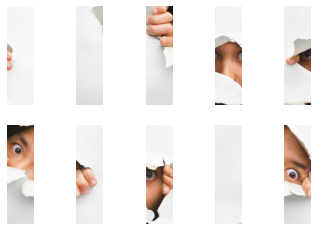

In [94]:
def show(images, rows, cols):
    fig = plt.figure()
    for i, image in enumerate(images):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.axis('off')
        ax.imshow(image)
    fig.show()

show(data.images, data.rows, data.cols)

In [95]:
def sim1(up, down):
    shape = np.min((up.shape, down.shape), axis=0)
    return (up[-1, :shape[1]] == down[0, :shape[1]]).sum()

def sim2(left, right):
    shape = np.min((left.shape, right.shape), axis=0)
    return (left[:shape[0], -1] == right[:shape[0], 0]).sum()

print(sim1(data.images[0], data.images[1]))
print(sim2(data.images[0], data.images[1]))

38
0


In [96]:
def build_model(data):
    model = pulp.LpProblem(sense=pulp.LpMaximize)
    x = np.array(pulp.LpVariable.matrix(
        'x',
        (range(data.size), range(data.rows), range(data.cols)),
        cat=pulp.LpBinary
    ))
    # yは疎なので、一括で生成しない
    y = {}

    costs = []
    for a in range(data.size):
        img1 = data.images[a]
        for b in range(data.size):
            if a == b:
                continue
            img2 = data.images[b]
            sim = (sim_x(img1, img2), sim_y(img1, img2))
            for row in range(data.rows):
                for col in range(data.cols):
                    if row < data.rows - 1:
                        y[a, b, row, col, row + 1, col] = pulp.LpVariable(
                            f'y_{a}_{b}_{row}_{col}_{row + 1}_{col}',
                            cat=pulp.LpBinary
                        )
                        costs.append(sim[0]*y[a, b, row, col, row + 1, col])
                    if col < data.cols - 1:
                        y[a, b, row, col, row, col + 1] = pulp.LpVariable(
                            f'y_{a}_{b}_{row}_{col}_{row}_{col + 1}',
                            cat=pulp.LpBinary
                        )
                        costs.append(sim[1]*y[a, b, row, col, row, col + 1])
    model.setObjective(pulp.lpSum(costs))


    for a in range(data.size):
        for b in range(data.size):
            if a == b:
                continue
            for row in range(data.rows):
                for col in range(data.cols):
                    if row < data.rows - 1:
                        model.addConstraint(
                            x[a, row, col] + x[b, row + 1, col] <= y[a, b, row, col, row + 1, col] + 1
                        )
                        model.addConstraint(
                            x[a, row, col] >= y[a, b, row, col, row + 1, col]
                        )
                        model.addConstraint(
                            x[b, row + 1, col] >= y[a, b, row, col, row + 1, col]
                        )
                    if col < data.cols - 1:
                        model.addConstraint(
                            x[a, row, col] + x[b, row, col + 1] <= y[a, b, row, col, row, col + 1] + 1
                        )
                        model.addConstraint(
                            x[a, row, col] >= y[a, b, row, col, row, col + 1]
                        )
                        model.addConstraint(
                            x[b, row, col + 1] >= y[a, b, row, col, row, col + 1]
                        )

    for a in range(data.size):
        model.addConstraint(
            x[a].sum() == 1
        )

    for row in range(data.rows):
        for col in range(data.cols):
            model.addConstraint(
                x[:, row, col].sum() == 1
            )

    return model, x

model, x = build_model(data)

In [97]:
solver = pulp.PULP_CBC_CMD(timeLimit=10*60*4, threads=4)

%time model.solve(solver)

CPU times: user 98.9 ms, sys: 15.3 ms, total: 114 ms
Wall time: 1min 14s


1

In [98]:
results = np.array(np.where(np.vectorize(lambda x: x.value())(x) == 1.))


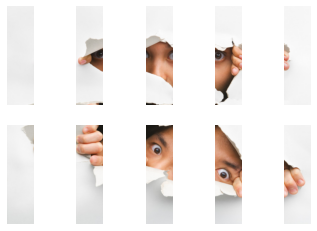

In [99]:
show(
    [data.images[_[0]] for _ in sorted(results.T, key=lambda x: (x[1], x[2]))],
    data.rows,
    data.cols
)